In [1]:
import pickle
import tensorflow as tf
import pandas as pd
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

# Read and Process Data

In [2]:
# All Games
df_games = pd.read_parquet("Data/nba_games.parquet").reset_index(drop=True).fillna(0)
# Player Games
df_player_games = pd.read_parquet("Data/player_game_stats.parquet").reset_index(drop=True).fillna(0)
# Team Rosters
df_team_rosters = pd.read_parquet("Data/team_rosters.parquet")

In [3]:
#Add Home Vs Away -> 0 = Away | 1 = Home
def home_or_away(matchup):

    if "@" in matchup:
        return 0
    else:
        return 1

In [4]:
df_games["side"] = df_games["MATCHUP"].apply(lambda x: home_or_away(x))

In [5]:
df_player_games = pd.merge(df_player_games, df_games[["MATCHUP", "GAME_ID", "TEAM_ID", "side"]], how="inner", left_on=["MATCHUP", "Game_ID"], right_on=["MATCHUP", "GAME_ID"])

In [6]:
def adjust_dtypes(df):

    use_category_cols = ["SEASON_ID", "GAME_ID", "TEAM_ID"]
    use_string_cols = ["TEAM_ABBREVIATION", "TEAM_NAME", "MATCHUP", "WL"]

    df["GAME_DATE"] = pd.to_datetime(df["GAME_DATE"])

    for col in use_category_cols:
        try:
            df[col] = df[col].astype('category')
        except Exception as e:
            df["Game_ID"] = df["Game_ID"].astype('category')
            df["Player_ID"] = df["Player_ID"].astype('category')

    for col in use_string_cols:
        if col in df.columns:
            df[col] = df[col].astype(str)
        else:
            pass

    return df

In [7]:
def get_game_averages(df):

    use_cols = ['PTS', 'FGM', 'FGA', 'FG_PCT',
       'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB',
       'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF']

    for col in use_cols:
        df[f"AVG_{col}"] = df.sort_values(["GAME_DATE"]).groupby(["TEAM_ID"])[col].expanding().mean().reset_index(0,drop=True)
    
    return df

In [8]:
def get_player_averages(df):

    use_cols = ['PTS', 'FGM', 'FGA', 'FG_PCT',
       'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB',
       'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF']

    for col in use_cols:
        df[f"AVG_{col}"] = df.sort_values(["GAME_DATE"]).groupby(["Player_ID"])[col].expanding().mean().reset_index(0,drop=True)
    
    return df

In [9]:
def create_target(Match, WL):
    if "@" in Match:
        if WL == "W":
            return 0
        else:
            return 1
    else:
        if WL == "W":
            return 1
        else:
            return 0

In [10]:
# Adjust Data Types
df_player_games = adjust_dtypes(df_player_games)
# Group By Team and Sort By Date - Calculate Running Average of Game Stats
df_games = get_game_averages(df_games)
# Group By Player and Sort By Date - Calculate Running Average of Player Stats
df_player_games = get_player_averages(df_player_games)

## Create Target Columns and Filter Out Bad Data

In [11]:
# Establish Win / Lose
df_games["target"] = df_games[["MATCHUP","WL"]].apply(lambda x: create_target(x[0],x[1]), axis=1)
# Establish Training Data
df_player_games[["target_id", "side"]] = df_player_games.sort_values(["GAME_DATE"]).groupby(["Player_ID"])[["Game_ID", "side"]].shift(-1)
df_games[["target_id", "side", "target"]] = df_games.sort_values(["GAME_DATE"]).groupby(["TEAM_ID"])[["GAME_ID", "side", "target"]].shift(-1)
# Drop Bad Training Data
df_player_games = df_player_games.dropna(subset="target_id")
df_games = df_games.dropna(subset="target_id")
df_player_games = df_player_games[df_player_games.groupby(["TEAM_ID","target_id"])["target_id"].transform("count")>= 10]
df_player_games = df_player_games[df_player_games.groupby(["target_id"])["target_id"].transform("count")>= 20]
df_games = df_games[df_games.groupby(["TEAM_ID", "target_id"])["target_id"].transform("count") == 1]
df_games = df_games[df_games.groupby(["target_id"])["target_id"].transform("count") == 2]

In [12]:
# Make Sure Both Datasets Line Up
df_player_games = df_player_games.loc[df_player_games["target_id"].isin(df_games["target_id"])]
df_games = df_games.loc[df_games["target_id"].isin(df_player_games["target_id"])]

## Create A Generator to Feed the Tensorflow Model

In [13]:
# OUTPUT --> HOME PLAYER AVERAGE + HOME TEAM AVERAGE + AWAY PLAYER AVERAGE + AWAY TEAM AVERAGE

def generate_data():
    
    for target_game in df_games.target_id.unique():

        # Game Data
        game = df_games[df_games["target_id"].values == target_game]
        home_team = game[game["side"].values == 1]
        away_team = game[game["side"].values == 0]

        # Team Data
        team = df_player_games[df_player_games["target_id"].values == target_game]
        home_players = team[team["side"].values == 1]
        away_players= team[team["side"].values == 0]
        home_players = home_players.sort_values("AVG_PTS", ascending=False).head(10)
        away_players = away_players.sort_values("AVG_PTS", ascending=False).head(10)

        # Target
        try:
            target = home_team["target"].values[0]
        except Exception as e:
            print(f"Target ID: {target}; Team Issue")
            continue

        # Drop Uneccesary Data From Columns
        home_team = home_team.drop(['SEASON_ID', 'TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_NAME', 'GAME_ID',
       'GAME_DATE', 'MATCHUP', 'WL', 'MIN', 'PTS', 'FGM', 'FGA', 'FG_PCT',
       'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB',
       'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PLUS_MINUS','target', 'target_id', 'side'], axis=1)

        away_team = away_team.drop(['SEASON_ID', 'TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_NAME', 'GAME_ID',
       'GAME_DATE', 'MATCHUP', 'WL', 'MIN', 'PTS', 'FGM', 'FGA', 'FG_PCT',
       'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB',
       'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PLUS_MINUS','target', 'target_id', 'side'], axis=1)

        home_players = home_players.drop(['SEASON_ID', 'Player_ID', 'Game_ID', 'GAME_DATE', 'MATCHUP', 'WL',
       'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA',
       'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF',
       'PTS', 'PLUS_MINUS', 'VIDEO_AVAILABLE', 'GAME_ID', 'TEAM_ID', 'target_id','side'], axis=1)

        away_players = away_players.drop(['SEASON_ID', 'Player_ID', 'Game_ID', 'GAME_DATE', 'MATCHUP', 'WL',
       'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA',
       'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF',
       'PTS', 'PLUS_MINUS', 'VIDEO_AVAILABLE', 'GAME_ID', 'TEAM_ID', 'target_id','side'],axis=1)

        if len(home_team) != 1 or len(away_team) != 1:
            #print(f"Target ID: {target_game}; Team Issue")
            continue
        elif len(home_players) != 10 or len(away_players) != 10:
            #print(f"Target ID: {target_game}; Player Issue")
            continue
        else:
            pass

        yield (home_players, home_team, away_players, away_team), target


# Set Up TF Data Pipeline

In [15]:
# Establish Size of Splits
DATASET_SIZE = 19011
train_size = int(0.8 * DATASET_SIZE)
val_size = int(0.1 * DATASET_SIZE)
test_size = int(0.1 * DATASET_SIZE)

In [16]:
output_signature = ((
                    tf.TensorSpec(shape = (10, 18), dtype = tf.float32),
                    tf.TensorSpec(shape = (1, 18), dtype = tf.float32),
                    tf.TensorSpec(shape = (10, 18), dtype = tf.float32),
                    tf.TensorSpec(shape = (1, 18), dtype = tf.float32)),
                    tf.TensorSpec(shape = (), dtype = tf.int16))

# Create TF Dataset and Shuffle
ds = tf.data.Dataset.from_generator(generate_data, output_signature=output_signature).shuffle(19017, seed=1997, reshuffle_each_iteration = False)#1738)

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2023-03-29 15:44:02.660581: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-29 15:44:02.660604: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [17]:
# Split Full Dataset into Train, Validation, Test
train_ds = ds.take(train_size)
val_ds = ds.skip(train_size).take(val_size)
test_ds = ds.skip(train_size).skip(val_size).batch(2056)

In [18]:
# Cache and Pre Fetch Data
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [19]:
# Batch Size
batch_size = 2056

# Establish Batch Size
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

In [20]:
# Define Steps Per Epoch & Validation Steps
steps_per_epoch = train_size//batch_size
val_steps = val_size//batch_size

# Create Model

In [21]:
def create_model():
    
    # Create Inputs For Numerical Data
    home_player_input = tf.keras.Input(shape = (10, 18), name="home_player_input")
    home_team_input = tf.keras.Input(shape = (1, 18), name="home_team_input")
    away_player_input = tf.keras.Input(shape = (10, 18), name="away_player_input")
    away_team_input = tf.keras.Input(shape = (1, 18), name="away_team_input")
    
    # Create First Branch
    x = tf.keras.layers.Dense(18, activation='relu')(home_team_input)
    x = tf.keras.layers.Normalization()(x)
    x = tf.keras.layers.Dense(18, activation='relu')(x)

    # Create Second Branch
    y = tf.keras.layers.Dense(180, activation='relu')(home_player_input)
    y = tf.keras.layers.Normalization()(y)
    y = tf.keras.layers.Dense(18, activation='relu')(y)

    # Create Third Brandch
    z = tf.keras.layers.Dense(18, activation='relu')(away_team_input)
    z = tf.keras.layers.Normalization()(z)
    z = tf.keras.layers.Dense(18, activation='relu')(z)

    # Create Fourth Branch
    w = tf.keras.layers.Dense(180, activation='relu')(away_player_input)
    w = tf.keras.layers.Normalization()(w)
    w = tf.keras.layers.Dense(18, activation='relu')(w)
    
    # Combine Branches
    xyz = tf.keras.layers.concatenate([x,y,z,w], axis=1)
    xyz = tf.keras.layers.Dense(18, activation='relu')(xyz)
    xyz = tf.keras.layers.Dense(18, activation='relu')(xyz)
    xyz = tf.keras.layers.Flatten()(xyz)
    output = tf.keras.layers.Dense(1, activation='sigmoid')(xyz)
    
    # Create Model
    model = tf.keras.Model(inputs=[home_player_input, home_team_input, away_player_input, away_team_input], outputs=output)
    
    return model

In [22]:
model = create_model()

model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.00005),
    run_eagerly=True,
    metrics=[
        tf.keras.metrics.AUC(num_thresholds=10000),
        "accuracy"
    ]
)

In [23]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 home_team_input (InputLayer)   [(None, 1, 18)]      0           []                               
                                                                                                  
 home_player_input (InputLayer)  [(None, 10, 18)]    0           []                               
                                                                                                  
 away_team_input (InputLayer)   [(None, 1, 18)]      0           []                               
                                                                                                  
 away_player_input (InputLayer)  [(None, 10, 18)]    0           []                               
                                                                                              

# Train Model

In [24]:
val_auc_call = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", restore_best_weights=True, start_from_epoch=200, patience=50)
auc_call = tf.keras.callbacks.EarlyStopping(monitor="accuracy", restore_best_weights=True, start_from_epoch=200, patience=50)
val_loss = tf.keras.callbacks.EarlyStopping(monitor="val_loss", restore_best_weights=True, start_from_epoch=200, patience=50)


callbacks = [val_auc_call, auc_call, val_loss]

In [25]:
history = model.fit(train_ds, epochs=2000, validation_data=val_ds, verbose=2, callbacks=callbacks, class_weight={0:1.25, 1:1})

Epoch 1/2000


2023-03-29 15:44:03.287173: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-03-29 15:44:13.299867: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1436 of 19017
2023-03-29 15:44:23.297597: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2887 of 19017
2023-03-29 15:44:33.302092: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 4339 of 19017
2023-03-29 15:44:43.301305: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5792 of 19017
2023-03-29 15:44:53.298689: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 7246 of 19017
2023-03-29 15:45:03.300803: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may tak

8/8 - 275s - loss: 1.0485 - auc: 0.5483 - accuracy: 0.6459 - val_loss: 0.7905 - val_auc: 0.5396 - val_accuracy: 0.6465 - 275s/epoch - 34s/step
Epoch 2/2000
8/8 - 1s - loss: 0.9139 - auc: 0.5447 - accuracy: 0.6459 - val_loss: 0.7100 - val_auc: 0.5318 - val_accuracy: 0.6465 - 1s/epoch - 134ms/step
Epoch 3/2000
8/8 - 1s - loss: 0.8167 - auc: 0.5410 - accuracy: 0.6459 - val_loss: 0.6644 - val_auc: 0.5254 - val_accuracy: 0.6465 - 792ms/epoch - 99ms/step
Epoch 4/2000
8/8 - 1s - loss: 0.7603 - auc: 0.5390 - accuracy: 0.6459 - val_loss: 0.6495 - val_auc: 0.5213 - val_accuracy: 0.6465 - 1s/epoch - 132ms/step
Epoch 5/2000
8/8 - 1s - loss: 0.7370 - auc: 0.5394 - accuracy: 0.6460 - val_loss: 0.6521 - val_auc: 0.5201 - val_accuracy: 0.6465 - 839ms/epoch - 105ms/step
Epoch 6/2000
8/8 - 1s - loss: 0.7321 - auc: 0.5414 - accuracy: 0.6459 - val_loss: 0.6581 - val_auc: 0.5207 - val_accuracy: 0.6465 - 745ms/epoch - 93ms/step
Epoch 7/2000
8/8 - 1s - loss: 0.7324 - auc: 0.5437 - accuracy: 0.6456 - val_loss

# Evaluate Model

## Examining Training Performance

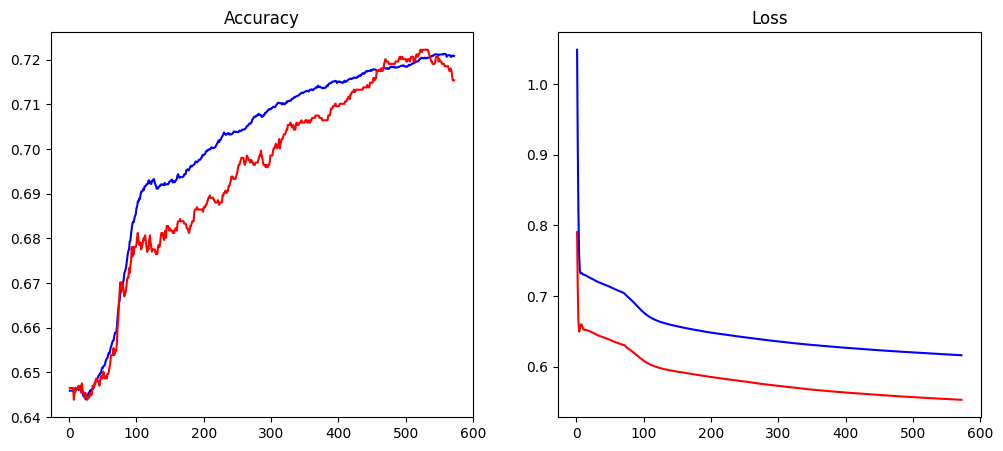

In [26]:
def plot_history(history):
    acc = history.history["accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    val_accuracy = history.history["val_accuracy"]
    
    x = range(1, len(acc) + 1)
    
    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, "b", label="training_acc")
    plt.plot(x, val_accuracy, "r", label="val_acc")
    plt.title("Accuracy")
    
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, "b", label="training_loss")
    plt.plot(x, val_loss, "r", label="val_loss")
    plt.title("Loss")
    
plot_history(history)

## Evaluating Model Performance on Unseen Data

In [27]:
results = model.evaluate(test_ds)

2023-03-29 15:55:08.162797: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1424 of 19017
2023-03-29 15:55:18.162246: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2869 of 19017
2023-03-29 15:55:28.160188: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 4312 of 19017
2023-03-29 15:55:38.161253: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5755 of 19017
2023-03-29 15:55:48.161223: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 7199 of 19017
2023-03-29 15:55:58.159992: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8642 of 19017
2023-03-29 15:56:08.161907: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling 

1/1 [==============================] - 132s 132s/step - loss: 0.5552 - auc: 0.7542 - accuracy: 0.7166


In [28]:
for num, metric in enumerate(model.metrics_names):
    print(f"{metric}: {results[num]}")

loss: 0.5551586747169495
auc: 0.7541762590408325
accuracy: 0.7166141271591187


In [29]:
if results[1] > .80 and results[0] < .30:
    model.save(f"LOSS_{round(results[0],2)}_ACC_{round(results[1],2)}_AUC_{round(results[2],2)}")
else:
    print("Shit's A Dud!") #55-75-71

Shit's A Dud!


## Evaluating Performance on Entire Dataset

In [31]:
x_ds = []
y_ds = []

for data in ds.as_numpy_iterator():
    x_ds.append(list(data[0]))
    y_ds.append(data[1])

2023-03-29 15:57:20.541464: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1443 of 19017
2023-03-29 15:57:30.544167: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2832 of 19017
2023-03-29 15:57:40.544289: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 4199 of 19017
2023-03-29 15:57:50.545839: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5630 of 19017
2023-03-29 15:58:00.546813: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 7041 of 19017
2023-03-29 15:58:10.547898: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8469 of 19017
2023-03-29 15:58:20.542369: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling 

In [32]:
predictions = model.predict(ds.batch(2056))

2023-03-29 15:59:36.063564: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1430 of 19017
2023-03-29 15:59:46.064344: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2863 of 19017
2023-03-29 15:59:56.061577: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 4295 of 19017
2023-03-29 16:00:06.066413: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5730 of 19017
2023-03-29 16:00:16.066249: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 7162 of 19017
2023-03-29 16:00:26.067260: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8596 of 19017
2023-03-29 16:00:36.063639: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling 

      4/Unknown - 132s 18ms/step

2023-03-29 16:01:38.100210: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


10/10 [==============================] - 132s 24ms/step


ROC_AUC Score :  0.760349958504506
Function for ROC_AUC Score :  0.760349958504506
Threshold value is: 0.5853949


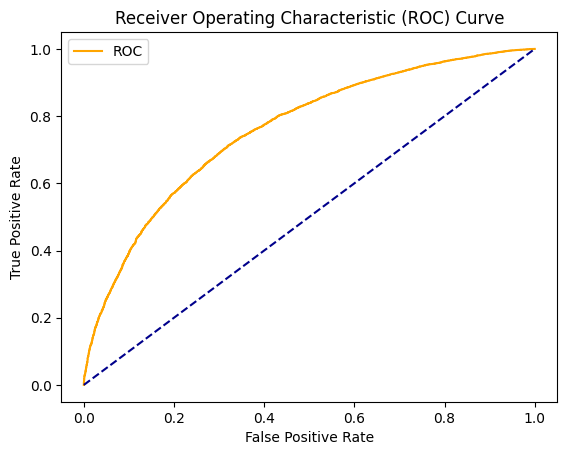

In [34]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()
# Computing manually fpr, tpr, thresholds and roc auc 
fpr, tpr, thresholds = roc_curve(y_ds, predictions)
roc_auc = auc(fpr, tpr)
print("ROC_AUC Score : ",roc_auc)
print("Function for ROC_AUC Score : ",roc_auc_score(y_ds, predictions)) # Function present
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)
plot_roc_curve(fpr, tpr)
#76

In [35]:
adj_predictions = [1 if i[0] > optimal_threshold else 0 for i in predictions]
print(accuracy_score(y_ds, adj_predictions))
print(roc_auc_score(y_ds, adj_predictions))
#69 - 76

0.7009099994739888
0.6962493959432305
